# Signature plots

This notebook illustrates the basic usage of signatures on Instacart customer analysis.
To use this notebook, one has to download the Instacart dataset. An easy way to do that is to execute the python file src/data/make_dataset.py (executing the next cell works as well).

Some paths might also have to be changed, depending on how jupyter was launched.

This notebook also shows how different algorithms (naive and widening instances) yield different signatures.

Feel free to play with the notebook!

In [1]:
# Execute this cell to download the Instacart dataset and build the customer files.
%run ../src/data/make_dataset.py

Getting dataset link
Got dataseet link, downloading now
Download done
Uncompressing ./instacart_data.tar.gz
Existing uncompressed directory, skipping uncompress data file
Building json customer file (this will take around 5 minutes, and about 6 Gb of RAM at most)
Existing customer file, skipping customer file creation
Finished building customer file


In [2]:
import os
import sys
import json
import matplotlib.pyplot as plt
import pandas as pd
import datetime

if os.getcwd().endswith("notebooks"):
    sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
else:
    sys.path.append(os.getcwd())
from src.visualization import get_signature_plot
from src.mining.signature_mining import compute_widening_mdl_signature, compute_hybrid_mdl_signature

In [3]:
%matplotlib inline

In [4]:
# We set up the experiments in here and save it in the right place
now = datetime.datetime.now()
expe_dir_name = "./experiments_results/" + "signature_examples_" + \
           str(now.year) + "_" + str(now.month) + "_" + str(now.day) + "_" +str(now.hour) + "_" + str(now.minute)
if not os.path.exists(expe_dir_name):
    os.makedirs(expe_dir_name)

results_dir = os.path.join(expe_dir_name, "results")
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

expe_params = {}
## YOU MIGHT HAVE TO MODIFY THESE PATHS TO MATCH YOUR OWN STRUCTURE
expe_params["dataset_path"] = "../src/data/instacart_2017_05_01/all_customers.jsonl"
expe_params["signature_jar_path"] = "../src/resources/signatures.jar"
## MODIFY THIS TO PLOT ANOTHER CUSTOMER SIGNATURES
expe_params["customer_id"] = 35123


expe_params_file = os.path.join(expe_dir_name, "expe_params.txt")
with open(expe_params_file, "w") as f:
    json.dump(expe_params, f)

In [5]:
user_data = {}
current_nb_custs = 1
with open(expe_params["dataset_path"]) as f:
    for l in f:
        user = json.loads(l)
        if user["client_id"] == expe_params["customer_id"]:
            user_data = user
            break

user_data["baskets"] = [b for b in user_data["baskets"] if b["products"]]

In [6]:
# We compute the signature of the naive method
naive_method_sign = compute_hybrid_mdl_signature(user_data["baskets"],
                                         expe_params["signature_jar_path"],
                                         method="dynProgMax")

In [7]:
# We load the product names
data_dir = os.path.abspath(os.path.join(expe_params["dataset_path"], os.pardir))
nomenclature = pd.read_csv(os.path.join(data_dir, "products.csv"))
prod_names = nomenclature["product_name"].tolist()
inverse_token_dict = {k:prod_names[i] for i,k in enumerate(nomenclature["product_id"].tolist())}


Plotting signature from naive algorithm with MDL cost=5230.450


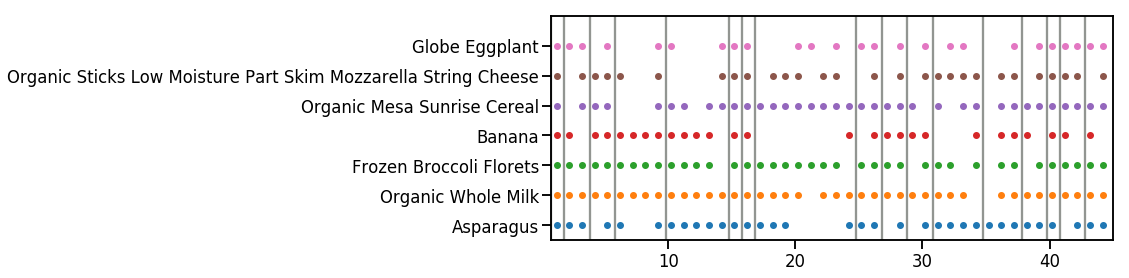

In [8]:
# Finally, we plot the signature of the naive method
fig, ax = get_signature_plot(naive_method_sign, user_data["baskets"],inverse_token_dict)
plt.gcf().subplots_adjust(left=0.25, bottom=0.1)
fig.savefig(os.path.join(results_dir, "naive_signature_user" + str(user_data["client_id"]) + ".pdf"))
print("Plotting signature from naive algorithm with MDL cost={:.3f}".format(naive_method_sign["cost"]))

Plotting signature for beam width of 1 and diversity of 0: MDL cost=5338.459
Plotting signature for beam width of 5 and diversity of 0: MDL cost=5297.829
Plotting signature for beam width of 5 and diversity of 0.3: MDL cost=5258.066
Plotting signature for beam width of 5 and diversity of 0.5: MDL cost=5242.411
Plotting signature for beam width of 20 and diversity of 0: MDL cost=5278.588
Plotting signature for beam width of 20 and diversity of 0.3: MDL cost=5233.801
Plotting signature for beam width of 20 and diversity of 0.5: MDL cost=5221.333


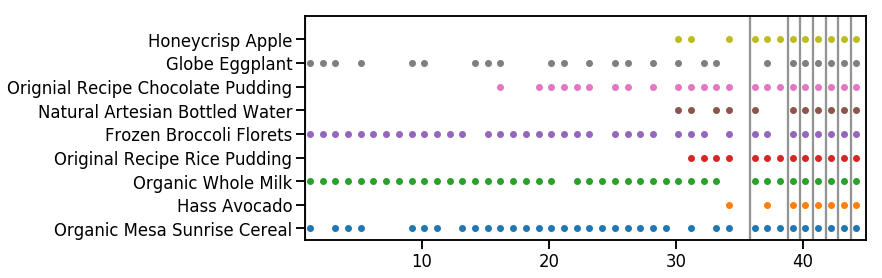

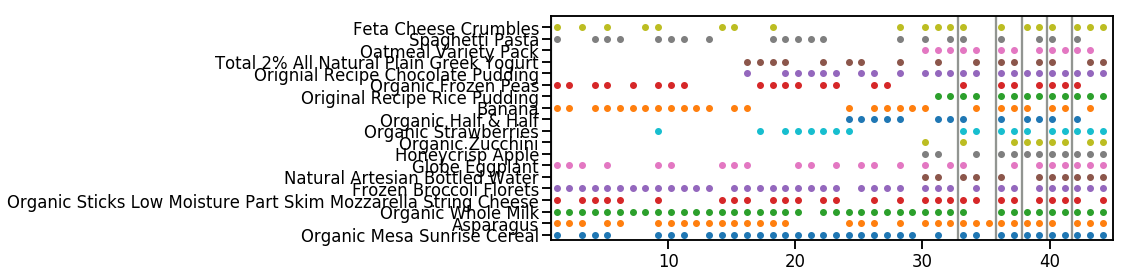

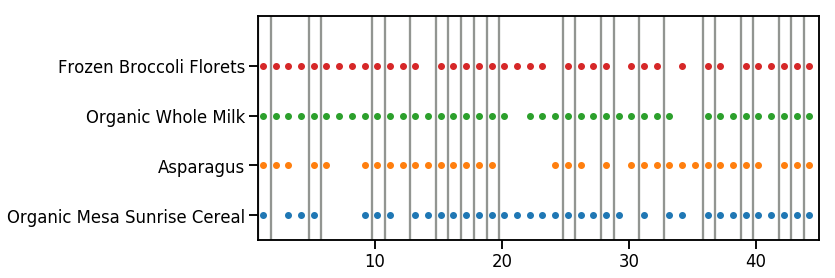

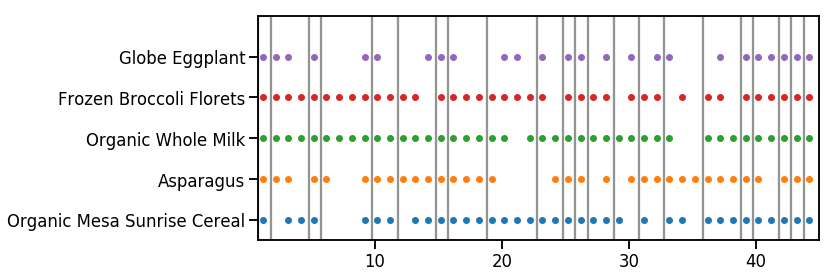

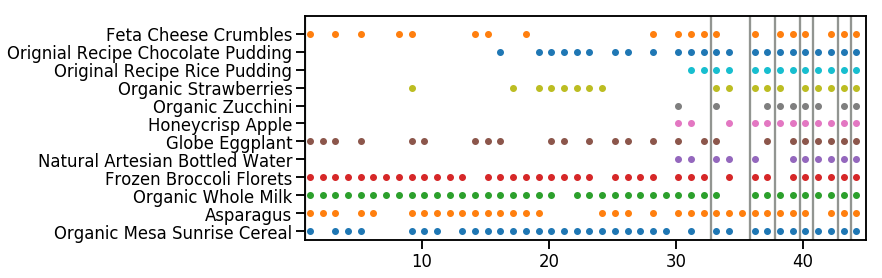

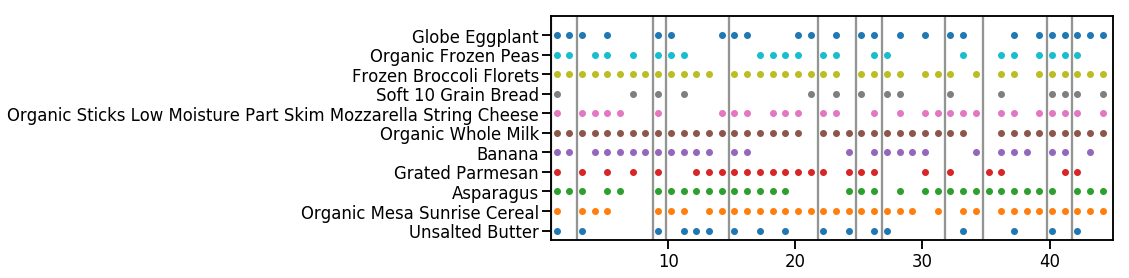

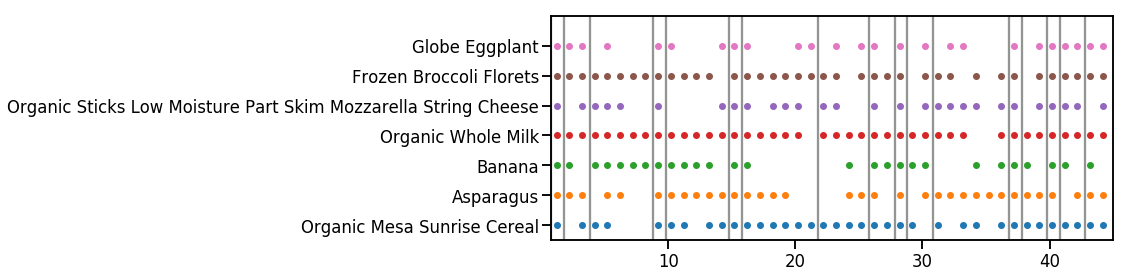

In [9]:
# We can now compute signatures for different widening version and plot them
beam_widths = [1, 5, 20]
betas = [0, 0.3, 0.5]
for beam_width in beam_widths:
    for beta in betas:
        if beam_width > 1 or beam_width == 1 and beta==0:
            widening_signature = compute_widening_mdl_signature(user_data["baskets"],
                                                                expe_params["signature_jar_path"],
                                                                beam_width=beam_width,
                                                                beta=beta)
            print("Plotting signature for beam width of {} and diversity of {}: MDL cost={:.3f}".format(beam_width, beta, widening_signature["cost"]))
            fig, ax = get_signature_plot(widening_signature, user_data["baskets"],inverse_token_dict)
            plt.gcf().subplots_adjust(left=0.25, bottom=0.1)
            fig.savefig(os.path.join(results_dir, "widening_w="+ str(beam_width) + "_b=" + str(beta) +"_signature_user" + str(user_data["client_id"]) + ".pdf"))
            plt.show()

One can see the influence of the beam width and diversity parameters.

As the beam increases, the code length decreases, and the quality of the signature improves.
The same can be said with the diversity parameter. The higher the diversity, the better (but too high diversity values are not recommended).

The best signature (also plotted in the paper) is the last one, for w=20 and beta=0.5

Overall, signature with small code length usually represents the whole purchase history better than signatures with high code length.
For this customer, signatures with high code lengths typically highlight only the recurrent behavior of the customer in the last transactions.

Feel free to modify the beta and beam widths parameters, as well as the customer id.